### Field-dependent aberrations arising when a Zernike on M1 segment is corrected with M2. 

In [37]:
import sys
import numpy as np
import math
import ceo
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

pupil sampling:      469 pixel
SH Pixel scale: 0.132arcsec
SH Field of view: 2.376arcsec


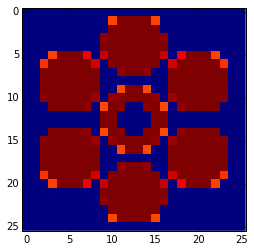

In [38]:
# Telescope parameters
D = 26.
nPx = 469
radial_order = 4
n_zern = (radial_order+1)*(radial_order+2)/2
gmt = ceo.GMT_MX(D,nPx,M1_radial_order=radial_order,M2_radial_order=radial_order)

# Off-axis GSs for field residuals evaluations
alpha_off = np.arange(0., 60.*10., 120.)  #  [in arcsec]
N_OFF = alpha_off.size
zenith_angle_off  = alpha_off*math.pi/180/3600 # in radians
azimuth_angle_off = np.zeros(N_OFF)       # in degrees

offgs = ceo.Source("R",zenith=zenith_angle_off,azimuth=azimuth_angle_off*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

# on-axis GS for wavefront sensing
ongs = ceo.Source("R",zenith=0.,azimuth=0., rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

# on-axis SH WFS parameters
nLenslet = 26  # number of sub-apertures across the pupil
n = 18         # number of pixels per subaperture
detectorRes = 2*n*nLenslet/2
BINNING = 2
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=BINNING,N_GS=1)

# Calibrate WFS slope null vector
ongs.reset()
gmt.reset()   # Telescope perfectly phased
gmt.propagate(ongs)
wfs.calibrate(ongs,0.8)
plt.imshow(wfs.flux.host(shape=(nLenslet,nLenslet)),interpolation='none')

print "pupil sampling:      %d pixel"%nPx
print "SH Pixel scale: %.3farcsec"%(wfs.pixel_scale_arcsec)
sh_fov = wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/BINNING
print "SH Field of view: %.3farcsec"%(sh_fov)

<matplotlib.colorbar.Colorbar instance at 0x2ac5ff6ba6c8>

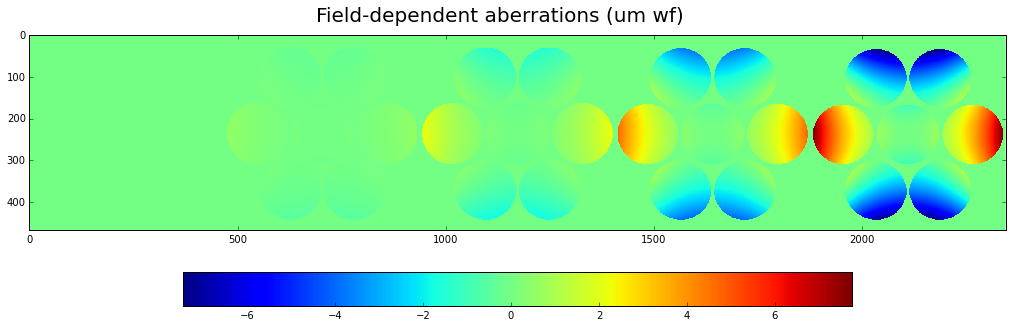

In [39]:
#Get residual WF solely due to telescope aberrations when perfectly aligned
offgs.reset()
gmt.reset()
gmt.propagate(offgs)
Wref = np.rollaxis( offgs.wavefront.phase.host(units='nm', shape=(1,offgs.N_SRC,offgs.n*offgs.m)),1,3)

ph_fda = offgs.phase.host(units='micron').T
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
fig.suptitle('Field-dependent aberrations (um wf)', fontsize=20)
imm = ax.imshow(ph_fda, interpolation='None')
fig.colorbar(imm, orientation='horizontal', shrink=0.6)

___ M2 ___
Segment #0: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #1: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #2: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #3: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #4: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #5: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #6: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
------------
(624, 98)


<matplotlib.colorbar.Colorbar instance at 0x2ac609b8c368>

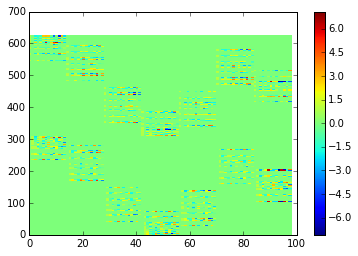

In [40]:
# Calibrate M2 segment Zernikes Interaction Matrix with on-axis WFS
# NOTE:  GMTILB.PY  modified to include TT in Zernikes !!!!

Zstroke = 50e-9 #m rms
D_M2_Z = gmt.calibrate(wfs, ongs, mirror="M2", mode="zernike", stroke=Zstroke)
print D_M2_Z.shape
nzernall = (D_M2_Z.shape)[1]  ## number of zernike DoFs calibrated

plt.pcolor(D_M2_Z)
plt.colorbar()

In [41]:
R_M2_Z = np.linalg.pinv(D_M2_Z)
print R_M2_Z.shape
print np.linalg.cond(D_M2_Z)

(98, 624)
5.97813441092


In [42]:
#### Define $\rho$ and $\theta$ coordinates on each mirror segment mask, at each FoV direction
Zobj = ceo.ZernikeS(radial_order)
P = np.rollaxis( np.array( offgs.rays.piston_mask ),0,3)

## Find center coordinates (in pixels) of each segment mask
u = np.arange(offgs.n)
v = np.arange(offgs.m)
x,y = np.meshgrid(u,v)
x = x.reshape(1,-1,1)
y = y.reshape(1,-1,1)
xc = np.sum(x*P,axis=1)/P.sum(axis=1)
yc = np.sum(y*P,axis=1)/P.sum(axis=1)
#plt.plot(alpha_off/60,xc[(0,3,6),:].T,'-+')

## Preliminary estimation of radius (in pixels) of each segment mask (assuming that there is no central obscuration)
Rs = np.sqrt(P.sum(axis=1)/np.pi)

## Polar coordinates
rho   = np.hypot(   x - xc[:,np.newaxis,:], y - yc[:,np.newaxis,:])   #temporal rho vector
theta = np.arctan2( y - yc[:,np.newaxis,:], x - xc[:,np.newaxis,:]) * P

## Estimate central obscuration area of each segment mask
ObsArea = np.sum(rho < 0.9*Rs[:,np.newaxis,:] * ~P.astype('bool'), axis=1)

## Improve estimation of radius of each segment mask
Rs = np.sqrt( (P.sum(axis=1)+ObsArea) / np.pi)

## Normalize rho vector (unitary radius)
rho = rho / Rs[:,np.newaxis,:] * P #final rho vector

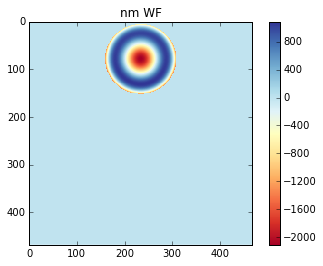

In [179]:
# Apply a Zernike vector to a particular segment on M1
segId = 4
aidx = np.arange(0,n_zern)
a_M1 = np.zeros(n_zern)   #zernike coeffs, from piston Z1 to n_zern
a_M1[10] = 500e-9      # m RMS surf

ongs.reset()
gmt.reset()
gmt.M1.zernike.a[segId-1,:] = a_M1
gmt.M1.zernike.update()
gmt.propagate(ongs)

plt.imshow(ongs.phase.host(units='nm'),interpolation='None',cmap='RdYlBu')
plt.colorbar()
plt.title("nm WF")

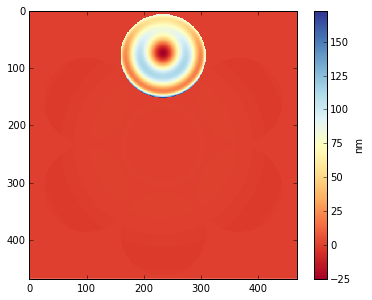

In [180]:
# Close the loop with the on-axis WFS commanding M2
f, ax = plt.subplots()
f.set_size_inches(6,8)

niter = 5
rmsval = np.zeros(niter)
a_M2 = np.zeros(nzernall)
for ii in range(5):
    ongs.reset()
    gmt.propagate(ongs)
    rmsval[ii] = ongs.wavefront.rms()
    wfs.reset()
    wfs.analyze(ongs)
    slopevec = wfs.valid_slopes.host().ravel()
    a_M2 += np.dot(R_M2_Z, slopevec) 
    atemp = a_M2.reshape((7,-1))
    gmt.M2.zernike.a[:,1:] = -atemp
    gmt.M2.zernike.update()
    #---- visualization
    if ii > 0: clb.remove()
    h = ax.imshow(ongs.phase.host(units='nm'),interpolation='None',cmap='RdYlBu')
    clb = f.colorbar(h, ax=ax, shrink=0.6)
    clb.set_label('nm')
    IPython.display.clear_output(wait=True)
    IPython.display.display(f)

plt.close()

[ 321.34215644   32.1590079    25.89649029   25.84491199   25.84425829]


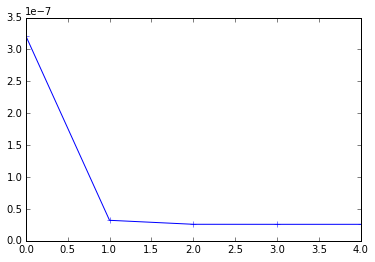

In [181]:
plt.plot(rmsval, '-+')
print rmsval*1e9

<matplotlib.colorbar.Colorbar instance at 0x2ac608992ea8>

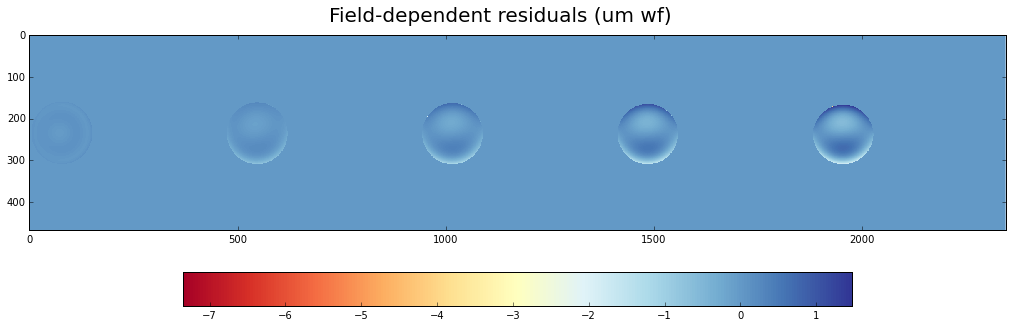

In [182]:
#Get residual WF solely due to telescope aberrations when perfectly aligned
offgs.reset()
gmt.propagate(offgs)
Wres = np.rollaxis( offgs.wavefront.phase.host(units='nm', shape=(1,offgs.N_SRC,offgs.n*offgs.m)),1,3)

ph_res = offgs.phase.host(units='micron').T
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
fig.suptitle('Field-dependent residuals (um wf)', fontsize=20)
imm = ax.imshow((ph_res-ph_fda), interpolation='None',cmap='RdYlBu')
fig.colorbar(imm, orientation='horizontal', shrink=0.6)

In [134]:
print np.unravel_index((ph_res-ph_fda).argmax(),ph_res.shape)

(228, 1882)


In [106]:
# Build an Zernike Influence-function Matrix for a GIVEN segment, and for ALL FoV directions

Zmat = np.zeros((nPx*nPx,Zobj.n_mode,N_OFF))
for alphaId in range(N_OFF):
    Zobj.reset()
    cutheta = ceo.cuDoubleArray(host_data=theta[segId-1,:,alphaId].reshape(ongs.m,ongs.n))
    curho   = ceo.cuDoubleArray(host_data=  rho[segId-1,:,alphaId].reshape(ongs.m,ongs.n))
    for k in range(Zobj.n_mode):
        Zobj.a[0,k] = 1
        Zobj.update()
        S = Zobj.surface(curho,cutheta).host(shape=(nPx*nPx,1))*P[segId-1,:,alphaId].reshape(-1,1)
        Zmat[:,k,alphaId] = S.flatten()
        Zobj.a[0,k] = 0

print Zmat.shape
#plt.imshow(Zmat[:,14,4].reshape(nPx,nPx))
#plt.colorbar()

(219961, 15, 5)


In [107]:
#Pseudo-inverse of Zmat
invZmat = np.zeros((Zobj.n_mode,nPx*nPx,N_OFF))
for alphaId in range(N_OFF):
    invZmat[:,:,alphaId] = np.linalg.pinv(Zmat[:,:,alphaId])
print invZmat.shape


(15, 219961, 5)


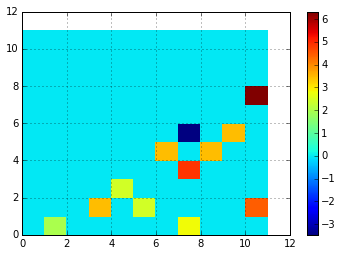

In [108]:
# theoretical Field dependent aberrations (McLeod 2014)
FDAdx = np.zeros((11,11))
FDAdx[0,1] = 2.  # Z2
FDAdx[1,3] = 2.*np.sqrt(3.) # Z4
FDAdx[2,4] = np.sqrt(6.)    # Z5
FDAdx[1,5] = np.sqrt(6.)    # Z6
FDAdx[4,6] = 2.*np.sqrt(3.) # Z7
FDAdx[(0,3,5),7] = (np.sqrt(8.), 2*np.sqrt(6.), -2*np.sqrt(3.))  #Z8
FDAdx[4,8] = 2.*np.sqrt(3.) # Z9
FDAdx[5,9] = 2.*np.sqrt(3.) # Z10
FDAdx[(1,7),10] = (2.*np.sqrt(5.),2.*np.sqrt(10.)) #Z11
plt.pcolor(FDAdx)
plt.colorbar()
plt.grid()

In [183]:
#Project FD residuals onto Zernike modes
arec = np.zeros((Zobj.n_mode, N_OFF))
for alphaId in range(N_OFF):
    arec[:,alphaId] = np.dot(invZmat[:,:,alphaId], (Wres-Wref)[:,:,alphaId].reshape(-1))
#print np.array_str(arec,precision=3,suppress_small=True)

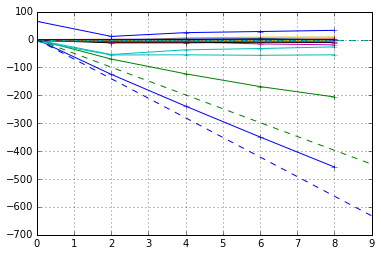

In [184]:
plt.plot(alpha_off/60, arec.T, '-+')
plt.grid()
#plt.legend(loc=3, fontsize='large')
plt.hold('True')
plt.gca().set_color_cycle(None)
# theoretical curve according to Brian's tech note
gmt_const = 1.11e-2   # arcmin^{-1}
theo_angle = np.arange(10) # in arcmin
atheo = np.dot(FDAdx, a_M1[0:11]) * gmt_const * (1e9*2)
theo_curve = atheo[np.newaxis,:] * theo_angle[:,np.newaxis]
plt.plot(theo_angle,-theo_curve, '--')
plt.hold('False')

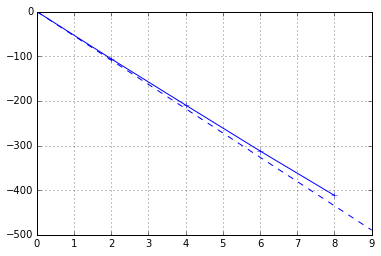

In [100]:
#one at a time, just in case flexibility is needed
plt.plot(alpha_off/60, arec[1,:], 'b-+')
plt.hold('True')
plt.grid()
theo_curve = gmt_const * a_M1[5] * 1e9 * 2 * np.sqrt(6.) * theo_angle
plt.plot(np.arange(10),-theo_curve, 'b--')
plt.hold('False')